<h1> Lab </h1>

This lab serves as an explanation of how FGSM attack works as one of the ways an input attack can be executed. Take away the idea that noise can be added on the input and change its loss function such that it gets misclassified by the AI model.

This is a lead onto poisoning and backdoor attacks that could be applied in the commercial banking example in: <a> https://github.com/weijie-lim/IS613_G1_cybersecurity_tech_and_app_project_secure_ai/blob/main/FGSM%20Attack%20on%20Commercial%20Check%20Recognition%20Systems%20%20-%20Fast%20Gradient%20Signed%20Method.ipynb </a>

<h3> White-box vs Black-box attacks </h3>
A white-box attack assumes the attacker has full knowledge and access to the model, including architecture, inputs and outputs and weights.

A black-box attack assumes the attacker only has access to the inputs and outputs of the model and knows nothing about the underlying architecture or weights. 


<h3> Goals </h3>
There are also several types of goals, including misclassification and source/target misclassification. 

A goal of misclassification means the adversary only wants the output classification to be wrong but does not care what the new classification is. 

A source/target misclassification means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.


<h3> FGSM </h3>
In this case, the FGSM attack is a white-box attack with the goal of misclassification

<h3> Example From the Slides </h3>

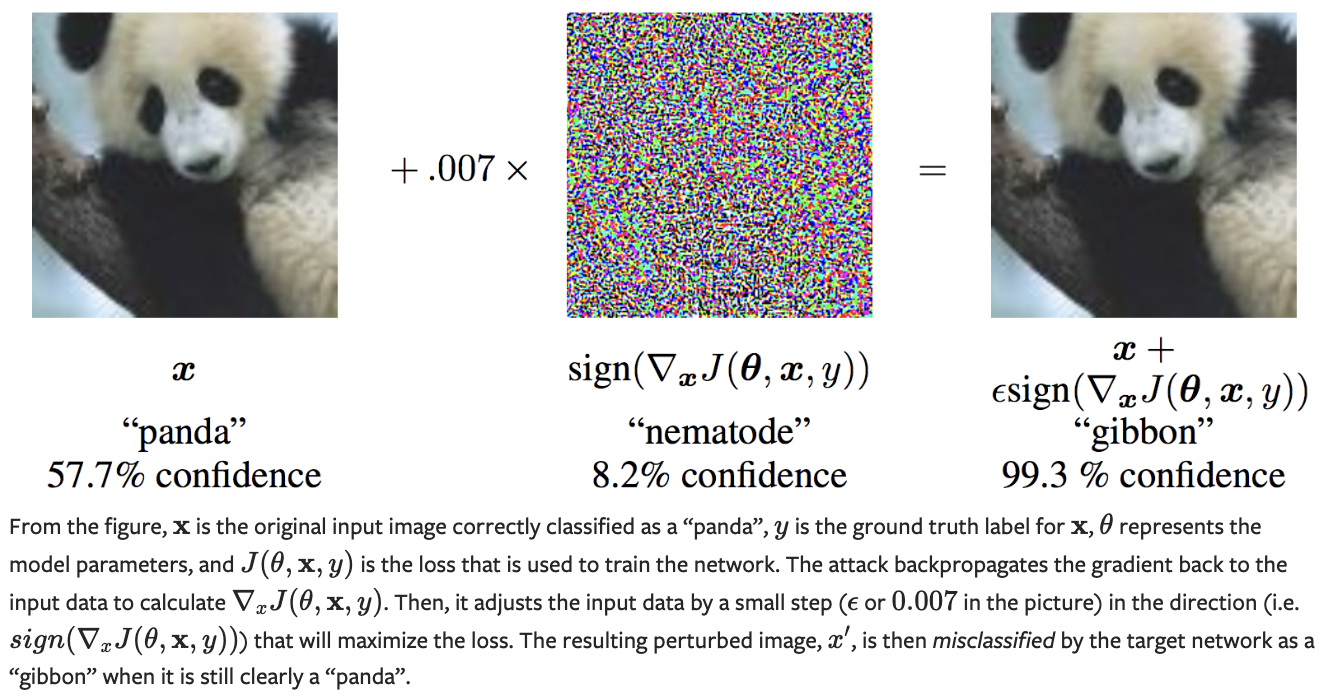

In [1]:
#Implementation

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

<h3> Required Inputs </h3>

Epsilon - The larger the epsilon, the more noticeable the perturbations, but also the more effective the attack in terms of degrading the model accuracy.

Pretrained model - download the pretrained model here: https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h 

In [2]:
epsilons = [0, 0.0001, 0.0005, .001, .005, .01, .05, .1, .15, .2, .25, .3, .5, .6, .7, .8, .9]
pretrained_model = "/Users/limweijie/Downloads/lenet_mnist_model.pth"
use_cuda=False

<h3> Train the Model </h3>

Define the model, dataloader and initialize the model and load the pretrained weights.

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
device = torch.device("cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

<h3> Carry out the FGSM Attack </h3>

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

<h3> Test Function </h3>

The central result of this tutorial comes from the test function. Each call to this test function performs a full test step on the MNIST test set and reports a final accuracy. However, notice that this function also takes an epsilon input. This is because the test function reports the accuracy of a model that is under attack from an adversary with strength \epsilonϵ. More specifically, for each sample in the test set, the function computes the gradient of the loss w.r.t the input data (data\_graddata_grad), creates a perturbed image with fgsm_attack (perturbed\_dataperturbed_data), then checks to see if the perturbed example is adversarial. In addition to testing the accuracy of the model, the function also saves and returns some successful adversarial examples to be visualized later.

In [5]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

<h3> Run the Attack </h3>

In [6]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.0001	Test Accuracy = 9809 / 10000 = 0.9809
Epsilon: 0.0005	Test Accuracy = 9808 / 10000 = 0.9808
Epsilon: 0.001	Test Accuracy = 9805 / 10000 = 0.9805
Epsilon: 0.005	Test Accuracy = 9786 / 10000 = 0.9786
Epsilon: 0.01	Test Accuracy = 9746 / 10000 = 0.9746
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869
Epsilon: 0.5	Test Accuracy = 63 / 10000 = 0.0063
Epsilon: 0.6	Test Accuracy = 56 / 10000 = 0.0056
Epsilon: 0.7	Test Accuracy = 77 / 10000 = 0.0077
Epsilon: 0.8	Test Accuracy = 124 / 10000 = 0.0124
Epsilon: 0.9	Test Accuracy = 176 / 10000 = 0.0176


<h3> Results - Accuracy vs Epsilon</h3>

As epsilon increases, the test accuracy decreases. This is because larger epsilons mean we take a larger step in the direction that will maximize the loss. Notice the trend in the curve is not linear even though the epsilon values are linearly spaced.

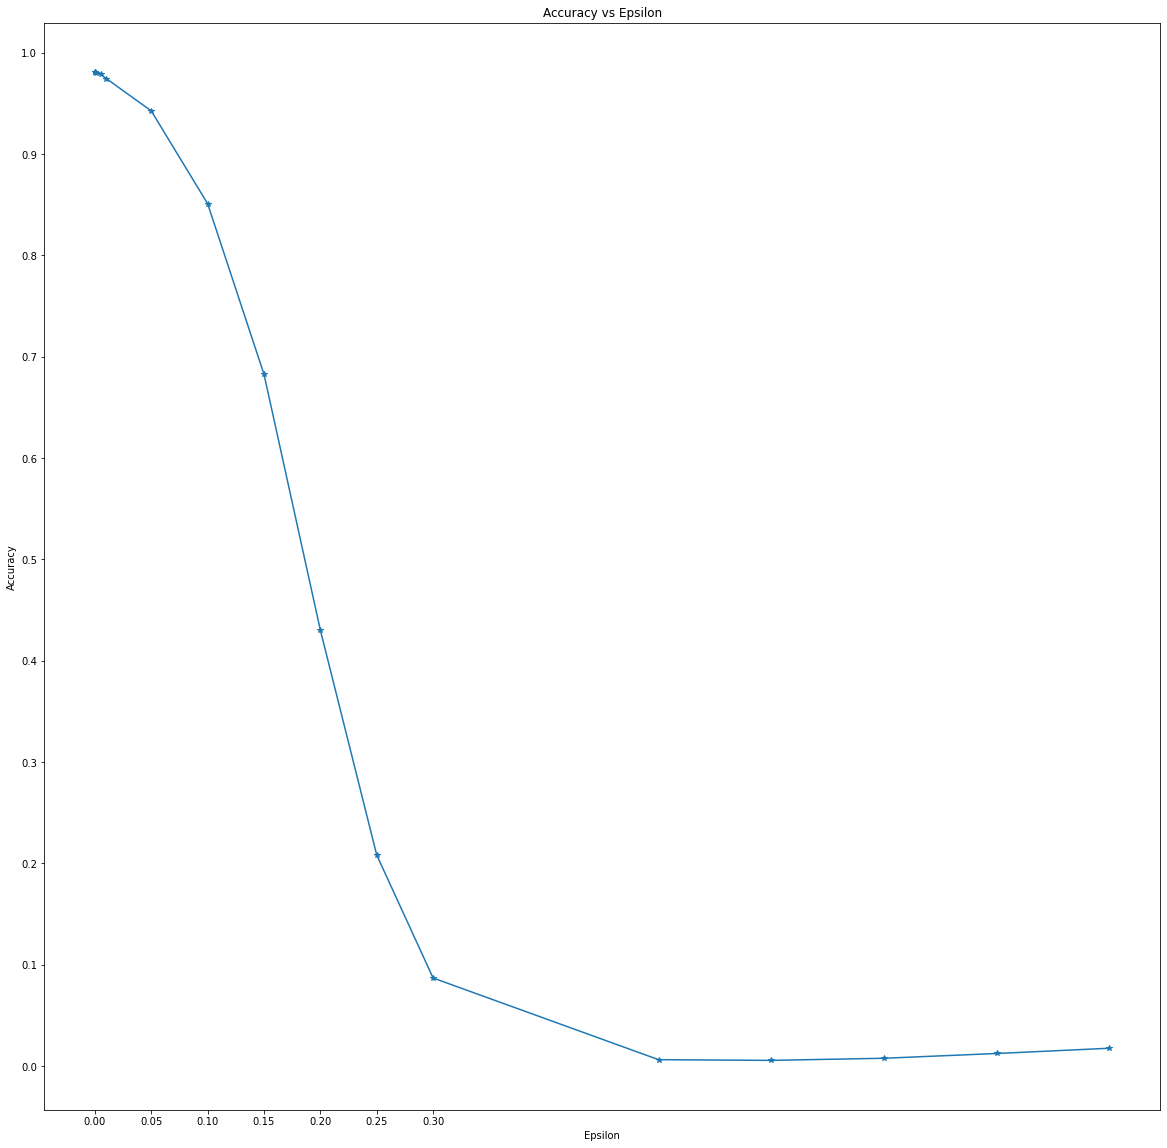

In [7]:
plt.figure(figsize=(20,20))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<h3> Sample Adversarial Examples </h3>

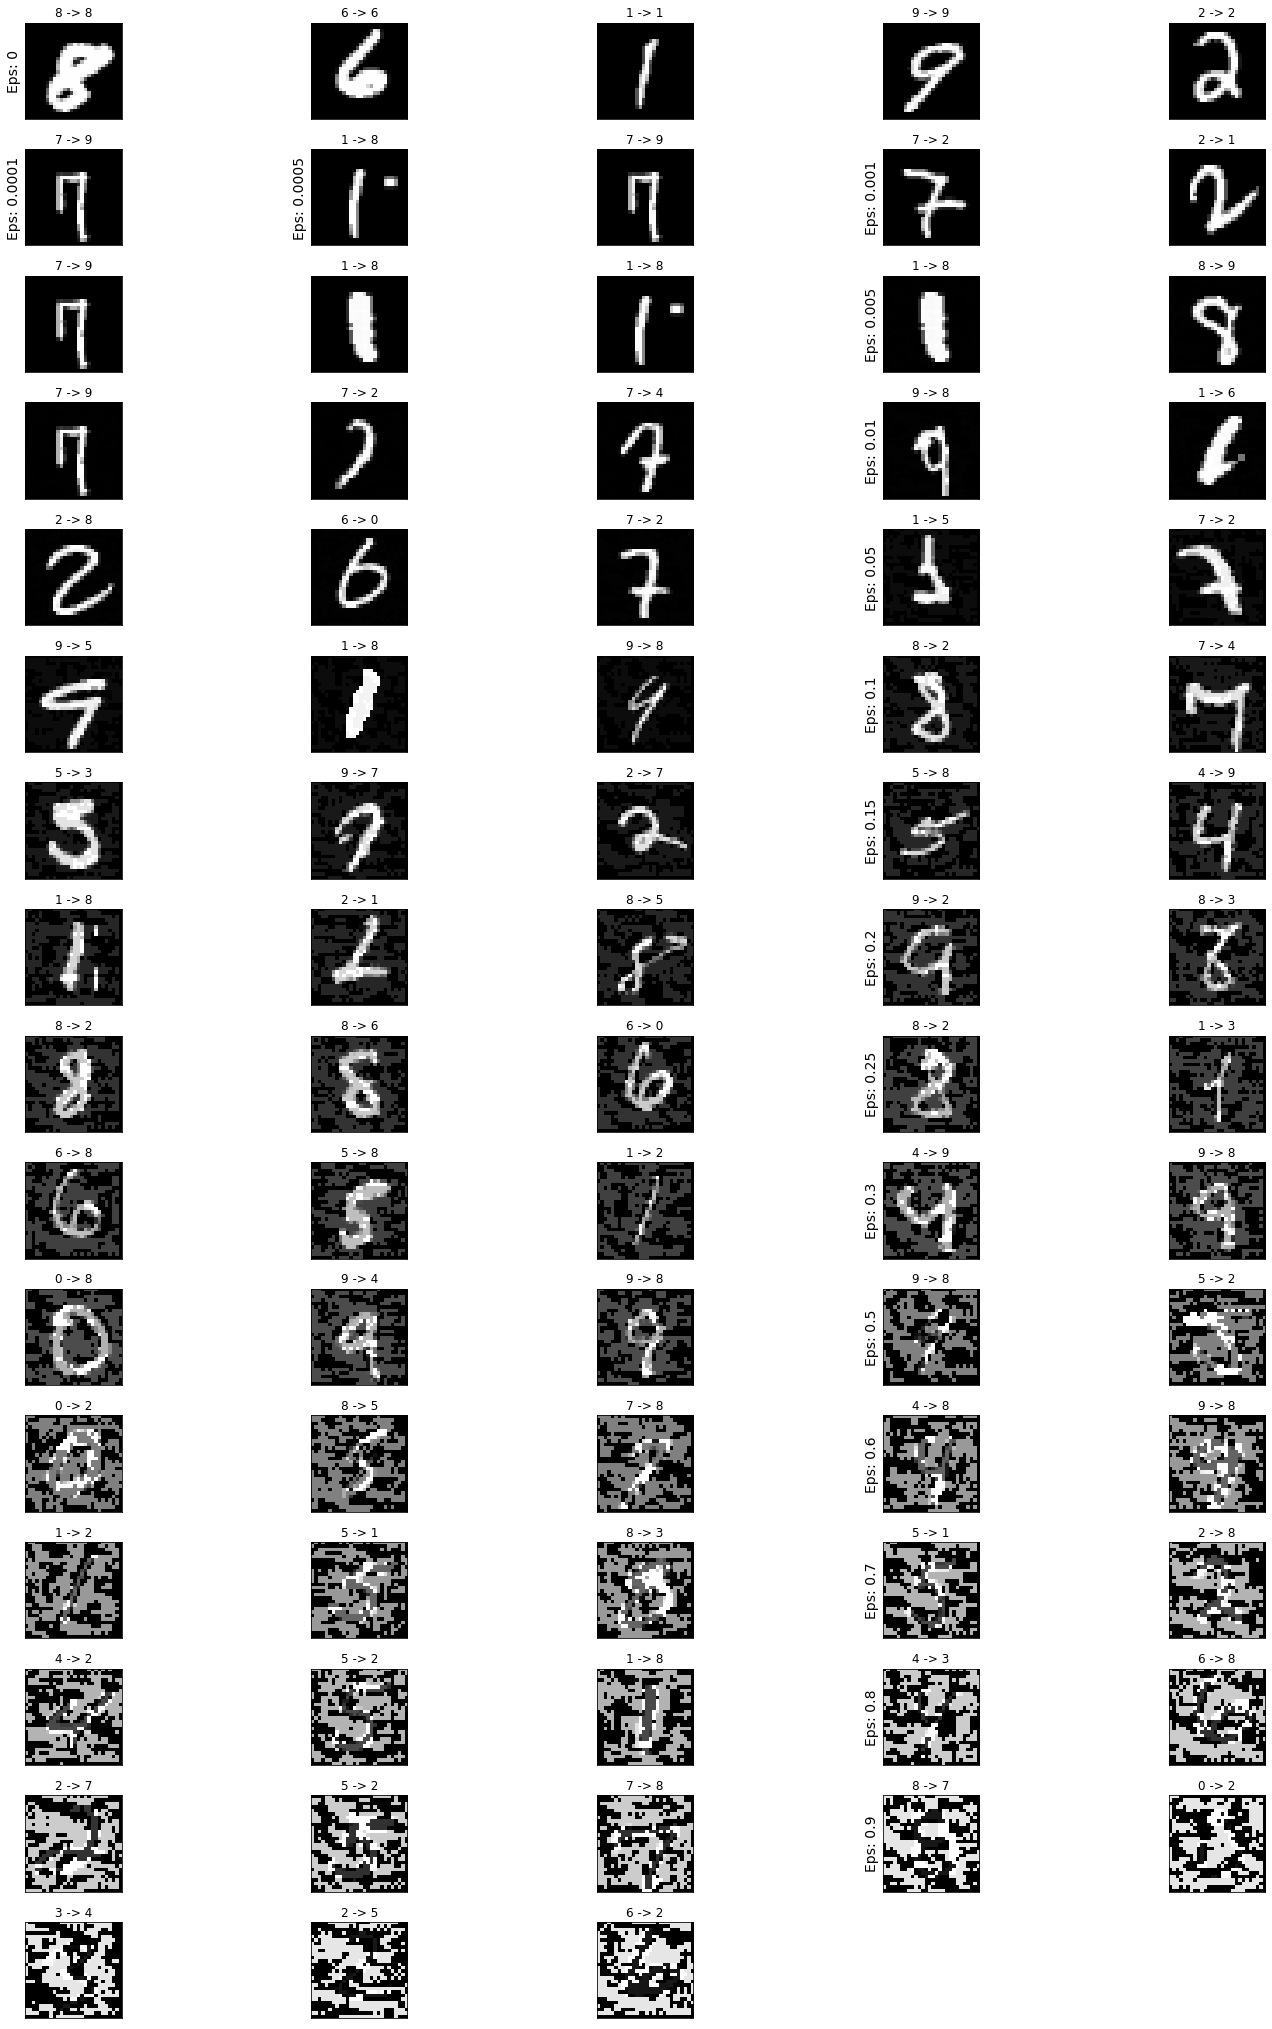

In [8]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

<h4> Credits </h4>
Nathan Inkawhich <a> https://github.com/pytorch/tutorials/blob/master/beginner_source/fgsm_tutorial.py </a>